In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [2]:
users = pd.read_csv('takehome_users.csv')
engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Find the sum of null values in the columns of the user dataframe.

In [7]:
users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

Almost half of the users were not invited by another user, leaving a value of NaN. Since there are no user ids of 0, we can fill in the missing values with 0 so the models can handle the dataframe.

In [8]:
users.invited_by_user_id.fillna(0, inplace = True)

For consistency, the 'object_id' column in the users dataframe will be renamed 'user_id'.

In [9]:
users.rename(columns = {"object_id":"user_id"}, inplace = True)

About a quarter of the last_session_creation_time values are NaN. We can use the time_stamps column from the engagement table to see why these values are NaN.

In [10]:
latest_logins = engagement.sort_values('time_stamp', ascending = False).drop_duplicates('user_id').drop(columns = 'visited')

In [11]:
merged = users.merge(latest_logins, on=['user_id'], how="left")
merged.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
time_stamp                    3177
dtype: int64

Since the time_stamp and last_session_created_time columns have the same values, we can conclude that there is no missing data; these 3,177 users just never logged in. Considering this is a sizeable proportion of the users dataframe, about 25%, eliminating the NaN's is not recommended. Instead, we will make the last_session_created_time the same as the time_stamp in the engagement table.

In [12]:
users.dropna(subset=["last_session_creation_time"], inplace = True)
users.creation_time = pd.to_datetime(users.creation_time)
users.creation_time = users.creation_time.values.astype(float) // 10**9

In [13]:
users.last_session_creation_time.fillna(users.creation_time, inplace = True)
users.isna().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

<h2>Creating variable for adopted users</h2>

In this project, the definition of an adopted user is a user that logged in at least 3 times over a one-week (7-day) period. The task is to identify which factors best predict whether or not a user will become an adopted user.

First, we need to convert the creation_time, last_session_creation_time, and time_stamp columns to datetime, and then convert the creation_time and last_session_creation_time to numeric for future analysis.

In [14]:
users['creation_time'] = pd.to_numeric(pd.to_datetime(users['creation_time']))
users['last_session_creation_time'] = pd.to_numeric(pd.to_datetime(users['last_session_creation_time'], unit="s"))
users['last_session_creation_time'] = users.last_session_creation_time.fillna(users['creation_time'])

In [16]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [17]:
#Set the time_stamp as index to group by week
grouped = engagement.set_index('time_stamp')
grouped = grouped.groupby(['user_id', pd.Grouper(freq='W')])['visited'].sum().reset_index()
grouped.head()

,user_id,time_stamp,visited
0,1,2014-04-27,1
1,2,2013-11-17,1
2,2,2013-12-01,1
3,2,2013-12-15,1
4,2,2013-12-29,1


In [18]:
#Isolate the users with 'visited' values of 3 or more.
adopted = grouped[grouped['visited'] >= 3]
adopted = adopted.drop_duplicates(subset='user_id', keep="first")
adopted.head()

,user_id,time_stamp,visited
7,2,2014-02-09,3
23,10,2013-03-03,3
96,20,2014-03-16,3
110,33,2014-03-23,3
126,42,2012-12-30,4


In [19]:
#Make new variable, adopted_user, the target variable.
adopted_users = adopted['user_id'].values
users['adopted_user'] = users['user_id'].apply(lambda u_id: 1 if u_id in adopted_users else 0)
users.head()

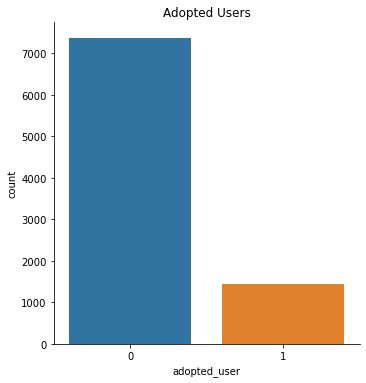

In [22]:
#Find the proportion of users that are adopted users.
sns.catplot(x='adopted_user', kind='count', data=users)
plt.title('Adopted Users')
plt.show()

In [23]:
round(users.adopted_user.value_counts(normalize=True), 4) * 100

0    83.62
1    16.38
Name: adopted_user, dtype: float64

Only about 16.38% of users are adopted users.

<h3>Feature Encoding</h3>
One hot encoding will be used to represent each category of 'creation_source', since it is categorical and not all models can interpret categorical variables.

In [24]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(users.creation_source)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
encodings = enc.fit_transform(integer_encoded)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [25]:
encoding = pd.DataFrame(encodings, columns = ["Guest_Invite", "Org_Invite", "Personal_Projects", "Signup", \
                                              "Signup_Google_Auth"])

encoding.reset_index(inplace=True)
users.reset_index(inplace = True)
users = pd.concat([users, encoding], axis = 1)
users.drop(columns = ["index"], inplace = True)
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,Guest_Invite,Org_Invite,Personal_Projects,Signup,Signup_Google_Auth
0,1,1398138810,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810000000000,1,0,11,10803.0,0,1.0,0.0,0.0,0.0,0.0
1,2,1384487104,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504000000000,0,0,1,316.0,1,0.0,1.0,0.0,0.0,0.0
2,3,1363734892,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892000000000,0,0,94,1525.0,0,0.0,1.0,0.0,0.0,0.0
3,4,1369123768,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168000000000,0,0,1,5151.0,0,1.0,0.0,0.0,0.0,0.0
4,5,1358417660,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660000000000,0,0,193,5240.0,0,1.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='creation_source'>

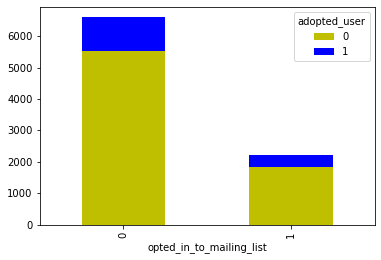

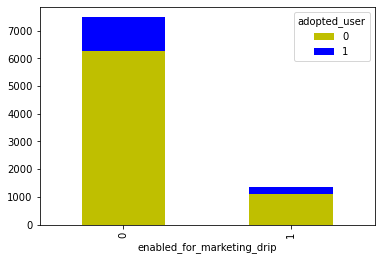

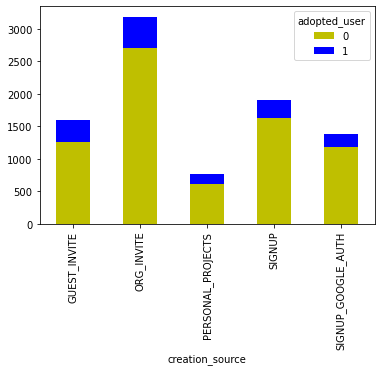

In [26]:
users.groupby(['opted_in_to_mailing_list', 'adopted_user']).size().unstack().plot(kind='bar', stacked=True, color = ['y', 'b'])
users.groupby(['enabled_for_marketing_drip', 'adopted_user']).size().unstack().plot(kind='bar', stacked=True, color = ['y', 'b'])
users.groupby(['creation_source', 'adopted_user']).size().unstack().plot(kind='bar', stacked=True, color = ['y', 'b'])

It seems that org_invite has a greater spread than the other variables shown.

<h3>Models</h3>

In [27]:
X = users[['creation_time', 'last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', \
           'org_id', 'invited_by_user_id', 'Guest_Invite', 'Org_Invite', 'Personal_Projects', 'Signup', \
           'Signup_Google_Auth']]
y = users['adopted_user']

In [28]:
clf = DecisionTreeClassifier(random_state=0)
estimator = clf
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X, y)
print("Feature Ranking: ", selector.ranking_)

Feature Ranking:  [1 1 6 8 1 2 3 4 5 9 7]


<h4>Rankings</h4>
<ul><li>creation_time: 1</li>
<li>last_session_creation_time: 1</li>
<li>opted_in_to_mailing_list: 6</li>
<li>enabled_for_marketing_drip: 8</li>
<li>org_id: 1</li>
<li>invited_by_user_id: 2</li>
<li>Guest_Invite: 3</li>
<li>Org_Invite: 4</li>
<li>Personal_Projects: 5</li>
<li>Signup: 9</li>
<li>Signup_Google_Auth: 7</li>
    
<p>The most important factors are creation time, last session creation time, and org_id.</p>

In [29]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state= 42)
clf.fit(X_train1,y_train1)
y_pred1 = selector.predict(X_test1)

print(confusion_matrix(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))
print('The accuracy of the Decision Tree model is:', accuracy_score(y_test1, y_pred1))

[[2200    0]
 [   0  447]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2200
           1       1.00      1.00      1.00       447

    accuracy                           1.00      2647
   macro avg       1.00      1.00      1.00      2647
weighted avg       1.00      1.00      1.00      2647

The accuracy of the Decision Tree model is: 1.0
